## IMPORTACIÓN LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## CARGAR ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

In [3]:
accesos24 = load_dataset('../data/Accessos 2024.xlsx')
accesos = load_dataset('../data/Copia de Accessos 01.01.2025 a 30.04.2025.xlsx')
accesos2 = load_dataset('../data/Copia de Accessos 01.05.2025 a 31.07.2025.xlsx')
accesos3 = load_dataset('../data/Copia de Accessos 01.08.2025 a 01.09.2025.xlsx')

Concatenamos los diferentes archivos en uno solo

In [4]:
def concatenar_dataframes(*dfs: pd.DataFrame) -> pd.DataFrame:
    """
    Concatenar una lista arbitraria de DataFrames en uno solo.
    
    Parámetros:
        *dfs: DataFrames a concatenar.
        
    Retorna:
        pd.DataFrame: DataFrame concatenado con índice reiniciado y copia.
    """
    concatenado = pd.concat(dfs, ignore_index=True)
    return concatenado.copy()

In [5]:
df_accesos = concatenar_dataframes(accesos24, accesos, accesos2, accesos3)
df_accesos

,IdPersona,Año,Mes,Dia,HEntrada,HSalida,HoraEntrada,HoraSalida
0,334,2024,9,10,10.0,11.0,10:51:48,11:32:57
1,334,2024,9,12,11.0,12.0,11:47:06,12:35:12
2,334,2024,9,17,10.0,11.0,10:48:53,11:50:54
3,2926,2024,10,24,15.0,15.0,15:24:59,15:43:37
4,2926,2024,11,7,11.0,13.0,11:20:52,13:37:48
...,...,...,...,...,...,...,...,...
213735,117358,2025,9,1,17.0,17.0,17:21:12,17:23:30
213736,117358,2025,9,1,18.0,19.0,18:00:35,19:10:51
213737,117360,2025,9,1,17.0,18.0,17:32:58,18:43:41
213738,117375,2025,9,1,18.0,19.0,18:58:55,19:17:02


In [6]:
def eda_basica(df: pd.DataFrame, nombre_df: str = "DataFrame") -> None:
    """
    Realiza un análisis exploratorio básico sobre un DataFrame:
    - Identifica variables numéricas y categóricas
    - Detecta valores nulos y muestra una visualización si los hay
    - Revisa duplicados (filas y columnas)

    Parámetros:
        df (pd.DataFrame): El DataFrame a analizar
        nombre_df (str): Nombre para mostrar del DataFrame (opcional)
    """
    print(f"\n📋 Análisis EDA básico de: {nombre_df}")

    # 1. Tipos de variables
    print("\n📌 Tipos de Variables:")
    num_vbles = df.select_dtypes(include='number').columns.tolist()
    cat_vbles = df.select_dtypes(exclude='number').columns.tolist()
    print(f"🔢 Variables Numéricas: {num_vbles}")
    print(f"🔠 Variables Categóricas: {cat_vbles}")

    # 2. Valores nulos
    print("\n🕳️ Variables con valores nulos:")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    missing_percentage = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Total Missing': missing,
        'Percentage Missing': missing_percentage
    })

    if not missing.empty:
        display(missing_df)
        plt.figure(figsize=(10, 6))
        missing.plot(kind='barh', color='salmon')
        plt.title("Variables con Valores Nulos")
        plt.xlabel("Cantidad de valores nulos")
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("✅ No hay valores nulos en el dataset.")

    # 3. Filas duplicadas
    print("\n📎 Filas duplicadas:")
    duplicadas = df.duplicated().sum()
    if duplicadas > 0:
        print(f"🔴 Hay {duplicadas} filas duplicadas.")
        display(df[df.duplicated()])
    else:
        print("✅ No hay filas duplicadas.")

    # 4. Columnas duplicadas
    print("\n📎 Columnas duplicadas:")
    columnas_duplicadas = df.T.duplicated().sum()
    if columnas_duplicadas > 0:
        print(f"🔴 Hay {columnas_duplicadas} columnas duplicadas.")
    else:
        print("✅ No hay columnas duplicadas.")


📋 Análisis EDA básico de: Clientes Accesos

📌 Tipos de Variables:
🔢 Variables Numéricas: ['IdPersona', 'Año', 'Mes', 'Dia', 'HEntrada', 'HSalida']
🔠 Variables Categóricas: ['HoraEntrada', 'HoraSalida']

🕳️ Variables con valores nulos:


,Total Missing,Percentage Missing
HEntrada,421,0.196968
HSalida,175,0.081875


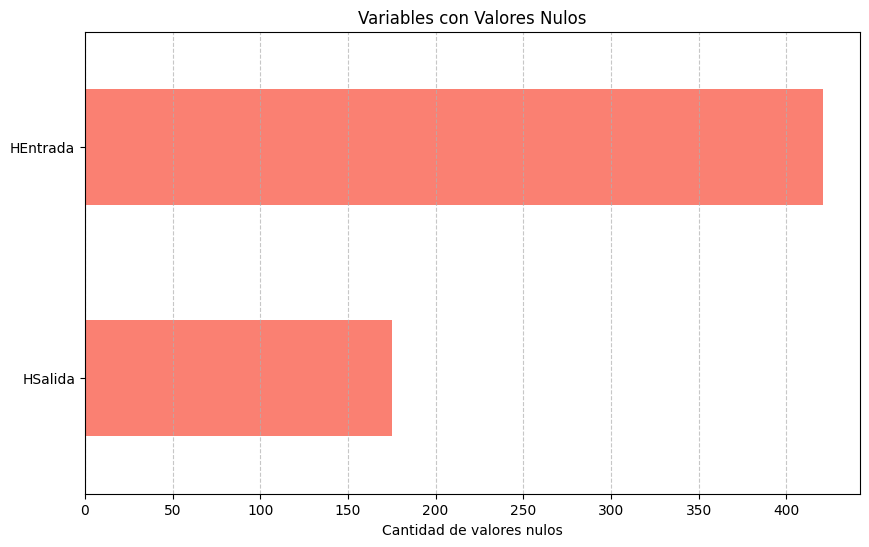


📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
✅ No hay columnas duplicadas.


In [7]:
eda_basica(df_accesos, nombre_df="Clientes Accesos")

In [8]:
def preparar_datos_iniciales(df: pd.DataFrame, columnas_a_eliminar: list,   columnas_a_renombrar: dict,
    columnas_numericas: list, columnas_fechas: list) -> pd.DataFrame:
    """
    Prepara un DataFrame para análisis exploratorio de datos (EDA).
    
    Parámetros:
        df (pd.DataFrame): DataFrame original
        columnas_a_eliminar (list): Columnas que se eliminarán del DataFrame
        columnas_a_renombrar (dict): Diccionario con columnas a renombrar {original: nuevo_nombre}
        columnas_numericas (list): Columnas que deben convertirse a tipo numérico
        columnas_fechas (list): Columnas que deben convertirse a tipo datetime
    
    Retorna:
        pd.DataFrame: DataFrame transformado
    """
    df_eda = df.copy()

    # Eliminar columnas
    df_eda.drop(columns=columnas_a_eliminar, inplace=True, errors='ignore')

    # Renombrar columnas
    df_eda.rename(columns=columnas_a_renombrar, inplace=True)

    # Conversión de columnas numéricas
    for col in columnas_numericas:
        if col in df_eda.columns:
            df_eda[col] = pd.to_numeric(df_eda[col], errors='coerce')

    # Conversión de columnas de fecha
    for col in columnas_fechas:
        if col in df_eda.columns:
            df_eda[col] = pd.to_datetime(df_eda[col], errors='coerce', dayfirst=True)

    return df_eda

In [9]:
columnas_a_eliminar = ['HEntrada', 'HSalida']
columnas_a_renombrar = {}
columnas_numericas = []
columnas_fechas = []

df_accesos_eda = preparar_datos_iniciales(df_accesos, columnas_a_eliminar, columnas_a_renombrar,
    columnas_numericas,   columnas_fechas)

Confirmamos que ya no no hay las columnas a eliminar 

In [10]:
eda_basica(df_accesos_eda, nombre_df="Clientes Accesos")


📋 Análisis EDA básico de: Clientes Accesos

📌 Tipos de Variables:
🔢 Variables Numéricas: ['IdPersona', 'Año', 'Mes', 'Dia']
🔠 Variables Categóricas: ['HoraEntrada', 'HoraSalida']

🕳️ Variables con valores nulos:
✅ No hay valores nulos en el dataset.

📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
✅ No hay columnas duplicadas.


#### -FEATURE ENGINEERING 

In [11]:
def preparar_fechas_y_horas(df_accesos: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara y limpia las columnas de fecha y hora en el DataFrame df_accesos.
    - Crea la columna 'Fecha' a partir de 'Año', 'Mes', 'Dia'.
    - Convierte y valida fechas, eliminando filas con fechas inválidas.
    - Convierte 'HoraEntrada' y 'HoraSalida' a objetos time.
    - Crea columnas 'FechaHoraEntrada' y 'FechaHoraSalida' combinando fecha y hora.
    
    Parámetros:
        df_accesos (pd.DataFrame): DataFrame con columnas Año, Mes, Dia, HoraEntrada, HoraSalida.
    
    Retorna:
        pd.DataFrame: DataFrame con las columnas preparadas y filas inválidas eliminadas.
    """
    df = df_accesos.copy()

    # Construir columna 'Fecha' en formato yyyy-mm-dd
    df['Fecha'] = (
        df['Año'].astype(int).astype(str) + '-' +
        df['Mes'].astype(int).astype(str).str.zfill(2) + '-' +
        df['Dia'].astype(int).astype(str).str.zfill(2)
    )

    # Convertir a datetime, ignorando errores
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

    # Eliminar filas con fechas inválidas
    df = df.dropna(subset=['Fecha']).reset_index(drop=True)

    # Convertir HoraEntrada y HoraSalida a datetime.time
    df['HoraEntrada'] = pd.to_datetime(
        df['HoraEntrada'].astype(str), format='%H:%M:%S', errors='coerce'
    ).dt.time

    df['HoraSalida'] = pd.to_datetime(
        df['HoraSalida'].astype(str), format='%H:%M:%S', errors='coerce'
    ).dt.time

    # Combinar fecha y hora en datetime
    df['FechaHoraEntrada'] = df.apply(
        lambda row: pd.Timestamp.combine(row['Fecha'], row['HoraEntrada']) if pd.notnull(row['HoraEntrada']) else pd.NaT, axis=1
    )

    df['FechaHoraSalida'] = df.apply(
        lambda row: pd.Timestamp.combine(row['Fecha'], row['HoraSalida']) if pd.notnull(row['HoraSalida']) else pd.NaT, axis=1
    )

    return df


In [12]:
df_accesos_preparado = preparar_fechas_y_horas(df_accesos_eda)

In [13]:
df_accesos_preparado

,IdPersona,Año,Mes,Dia,HoraEntrada,HoraSalida,Fecha,FechaHoraEntrada,FechaHoraSalida
0,334,2024,9,10,10:51:48,11:32:57,2024-09-10,2024-09-10 10:51:48,2024-09-10 11:32:57
1,334,2024,9,12,11:47:06,12:35:12,2024-09-12,2024-09-12 11:47:06,2024-09-12 12:35:12
2,334,2024,9,17,10:48:53,11:50:54,2024-09-17,2024-09-17 10:48:53,2024-09-17 11:50:54
3,2926,2024,10,24,15:24:59,15:43:37,2024-10-24,2024-10-24 15:24:59,2024-10-24 15:43:37
4,2926,2024,11,7,11:20:52,13:37:48,2024-11-07,2024-11-07 11:20:52,2024-11-07 13:37:48
...,...,...,...,...,...,...,...,...,...
212790,117358,2025,9,1,17:21:12,17:23:30,2025-09-01,2025-09-01 17:21:12,2025-09-01 17:23:30
212791,117358,2025,9,1,18:00:35,19:10:51,2025-09-01,2025-09-01 18:00:35,2025-09-01 19:10:51
212792,117360,2025,9,1,17:32:58,18:43:41,2025-09-01,2025-09-01 17:32:58,2025-09-01 18:43:41
212793,117375,2025,9,1,18:58:55,19:17:02,2025-09-01,2025-09-01 18:58:55,2025-09-01 19:17:02


In [14]:
import holidays

def calcular_features_accesos(df_accesos: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula features de accesos agrupados por IdPersona.

    Parámetros:
        df_accesos (pd.DataFrame): DataFrame con las columnas necesarias:
            - 'Fecha', 'FechaHoraEntrada', 'FechaHoraSalida', 'IdPersona',
            - 'duracion_min', 'hora_decimal', 'dia_semana', 'mes', 'estacion',
            - 'EsFestivo', 'EsFinDeSemana'.

    Retorna:
        pd.DataFrame: DataFrame con features agregadas por 'IdPersona'.
    """

    # Fechas importantes y preprocesamiento
    df_accesos = df_accesos.copy()
    df_accesos['Fecha'] = pd.to_datetime(df_accesos['Fecha'])
    df_accesos['FechaHoraEntrada'] = pd.to_datetime(df_accesos['FechaHoraEntrada'])
    df_accesos['FechaHoraSalida'] = pd.to_datetime(df_accesos['FechaHoraSalida'])

    # Calcular duracion_min si no existe
    if 'duracion_min' not in df_accesos.columns:
        df_accesos['duracion_min'] = (df_accesos['FechaHoraSalida'] - df_accesos['FechaHoraEntrada']).dt.total_seconds() / 60
    
    # Calcular hora_decimal, dia_semana y mes si no existen
    if 'hora_decimal' not in df_accesos.columns:
        df_accesos['hora_decimal'] = df_accesos['FechaHoraEntrada'].dt.hour + df_accesos['FechaHoraEntrada'].dt.minute / 60
    if 'dia_semana' not in df_accesos.columns:
        df_accesos['dia_semana'] = df_accesos['Fecha'].dt.dayofweek
    if 'mes' not in df_accesos.columns:
        df_accesos['mes'] = df_accesos['Fecha'].dt.month

    # Calcular estacion si no existe
    if 'estacion' not in df_accesos.columns:
        def estacion(mes):
            if mes in [12, 1, 2]: return 'invierno'
            elif mes in [3, 4, 5]: return 'primavera'
            elif mes in [6, 7, 8]: return 'verano'
            return 'otono'
        df_accesos['estacion'] = df_accesos['mes'].apply(estacion)

    # Crear indicadores de festivos y fines de semana si no existen
    if 'EsFestivo' not in df_accesos.columns or 'EsFinDeSemana' not in df_accesos.columns:
        festivos_cat_2024 = {
            '2024-01-01', '2024-01-06', '2024-04-18', '2024-04-21', '2024-05-01',
            '2024-06-17', '2024-06-24', '2024-08-15', '2024-09-11', '2024-11-01',
            '2024-12-06', '2024-12-08', '2024-12-25', '2024-12-26'
        }
        festivos_cat_2025 = {
            '2025-01-01', '2025-01-06', '2025-04-10', '2025-04-13', '2025-05-01',
            '2025-06-16', '2025-06-24', '2025-08-15', '2025-09-11', '2025-11-01',
            '2025-12-06', '2025-12-08', '2025-12-25', '2025-12-26'
        }
        festivos_cat = pd.to_datetime(list(festivos_cat_2024.union(festivos_cat_2025)))
        festivos_es = holidays.Spain(years=[2024, 2025])
        festivos_es_dates = pd.to_datetime(list(festivos_es.keys()))
        todos_festivos = festivos_es_dates.union(festivos_cat)

        df_accesos['EsFestivo'] = df_accesos['Fecha'].isin(todos_festivos)
        df_accesos['EsFinDeSemana'] = df_accesos['Fecha'].dt.dayofweek >= 5

    hoy = pd.Timestamp.today().normalize()

    def features_usuario(grp):
        fechas = grp['Fecha'].sort_values()
        if fechas.empty:
            return pd.Series()

        primera = fechas.min()
        ultima = fechas.max()
        total_dias = (ultima - primera).days or 1
        semanas_totales = total_dias // 7 + 1

        ultimos_30 = fechas[fechas >= (ultima - pd.Timedelta(days=30))]
        ultimos_90 = fechas[fechas >= (ultima - pd.Timedelta(days=90))]
        ultimos_180 = fechas[fechas >= (ultima - pd.Timedelta(days=180))]

        primer_tri = fechas[fechas < (primera + pd.Timedelta(days=90))]
        ultimo_tri = fechas[fechas > (ultima - pd.Timedelta(days=90))]

        diffs = fechas.diff().dt.days.dropna()
        racha_sin_visita = diffs.max() if not diffs.empty else 0

        fechas_range = pd.date_range(start=primera, end=ultima)
        presencia = fechas_range.isin(fechas)
        rachas, count = [], 0
        for v in presencia:
            if v:
                count += 1
            else:
                if count:
                    rachas.append(count)
                    count = 0
        if count:
            rachas.append(count)
        max_racha_visita = max(rachas) if rachas else 0

        semanas_con_visita = pd.DatetimeIndex(fechas).isocalendar().week.nunique()

        return pd.Series({
            'TotalVisitas': len(grp),
            'DiasActivo': fechas.nunique(),
            'TiempoActivoDias': total_dias,
            'VisitasUlt30': len(ultimos_30),
            'VisitasUlt90': len(ultimos_90),
            'VisitasUlt180': len(ultimos_180),
            'PropUlt90': len(ultimos_90) / len(grp) if len(grp) else np.nan,
            'DiasDesdeUltima': (hoy - ultima).days,
            'tasa_caida_visitas': len(ultimo_tri) / len(primer_tri) if len(primer_tri) else np.nan,

            'DuracionMediaTotal': grp['duracion_min'].mean(),
            'DuracionMediaUlt90': grp.loc[grp['Fecha'] >= (ultima - pd.Timedelta(days=90)), 'duracion_min'].mean(),
            'DeltaDuracionUlt90VsTotal': (
                (grp.loc[grp['Fecha'] >= (ultima - pd.Timedelta(days=90)), 'duracion_min'].mean() - grp['duracion_min'].mean())
                / grp['duracion_min'].mean() if grp['duracion_min'].mean() else np.nan
            ),

            'StdDiasEntreVisitas': diffs.std(ddof=0) if len(diffs) > 1 else 0,
            'FrecuenciaModal': diffs.mode()[0] if not diffs.empty else np.nan,
            'MaxRachaSinVisita': racha_sin_visita,
            'MaxRachaConVisita': max_racha_visita,
            'SemanasConVisitaRatio': semanas_con_visita / semanas_totales,

            'HoraMediaAcceso': grp['hora_decimal'].mean(),
            'DiaFavorito': grp['dia_semana'].mode()[0] if not grp['dia_semana'].empty else np.nan,
            'EstacionFavorita': grp['estacion'].mode()[0] if not grp['estacion'].empty else np.nan,

            'PropVisitasFinDeSemana': grp['EsFinDeSemana'].mean(),
            'PropVisitasFestivo': grp['EsFestivo'].mean(),

            'VisitasPrimerTrimestre': len(primer_tri),
            'VisitasUltimoTrimestre': len(ultimo_tri),
        })

    df_features = df_accesos.groupby('IdPersona').apply(features_usuario).reset_index()

    # Mapeo para dias de semana y estaciones
    dias_semana_map = {0: 'lunes', 1: 'martes', 2: 'miércoles', 3: 'jueves', 4: 'viernes', 5: 'sábado', 6: 'domingo'}
    df_features['DiaFavorito'] = df_features['DiaFavorito'].map(dias_semana_map).astype('category')
    df_features['EstacionFavorita'] = df_features['EstacionFavorita'].astype('category')

    # One-hot encoding para variables categóricas
    df_features = pd.get_dummies(df_features, columns=['DiaFavorito', 'EstacionFavorita'], prefix=['DiaFav', 'EstFav'])
    mediana_frec_modal = df_features['FrecuenciaModal'].median()
    df_features['FrecuenciaModal'].fillna(mediana_frec_modal, inplace=True)
    df_features['TieneAccesos'] = True
    return df_features


In [15]:
df_features_accesos= calcular_features_accesos(df_accesos_preparado)


In [16]:
pd.set_option('display.max_columns', None)

In [17]:
df_features_accesos

,IdPersona,TotalVisitas,DiasActivo,TiempoActivoDias,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,tasa_caida_visitas,DuracionMediaTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,StdDiasEntreVisitas,FrecuenciaModal,MaxRachaSinVisita,MaxRachaConVisita,SemanasConVisitaRatio,HoraMediaAcceso,PropVisitasFinDeSemana,PropVisitasFestivo,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,334,3,3,7,3,3,3,1.000000,394,1.000000,50.422222,50.422222,0.000000,1.500000,2.0,5.0,1,1.000000,11.144444,0.000000,0.000000,3,3,False,False,False,True,False,False,False,False,True,False,False,True
1,2476,4,4,56,2,4,4,1.000000,56,1.000000,81.408333,81.408333,0.000000,4.642796,14.0,25.0,1,0.444444,9.487500,0.000000,0.000000,4,4,False,True,False,False,False,False,False,False,False,False,True,True
2,2926,4,4,60,1,4,4,1.000000,303,1.000000,40.066667,40.066667,0.000000,14.514361,6.0,40.0,1,0.444444,15.662500,0.000000,0.000000,4,4,False,True,False,False,False,False,False,False,True,False,False,True
3,3461,36,35,358,2,4,5,0.111111,45,0.222222,95.457407,117.154167,0.227293,23.910650,1.0,116.0,6,0.288462,9.173611,0.166667,0.027778,18,4,False,False,True,False,False,False,False,False,True,False,False,True
4,4016,61,60,334,11,18,39,0.295082,51,9.000000,83.150820,88.990741,0.070233,14.171999,1.0,103.0,3,0.541667,12.221585,0.081967,0.016393,2,18,False,False,True,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,117360,1,1,1,1,1,1,1.000000,45,1.000000,70.716667,70.716667,0.000000,0.000000,1.0,0.0,1,1.000000,17.533333,0.000000,0.000000,1,1,False,False,True,False,False,False,False,False,True,False,False,True
6964,117375,1,1,1,1,1,1,1.000000,45,1.000000,18.116667,18.116667,0.000000,0.000000,1.0,0.0,1,1.000000,18.966667,0.000000,0.000000,1,1,False,False,True,False,False,False,False,False,True,False,False,True
6965,117412,1,1,1,1,1,1,1.000000,45,1.000000,8.516667,8.516667,0.000000,0.000000,1.0,0.0,1,1.000000,17.416667,0.000000,0.000000,1,1,False,False,True,False,False,False,False,False,True,False,False,True
6966,117613,6,6,45,3,6,6,1.000000,85,1.000000,84.072222,84.072222,0.000000,15.504838,1.0,40.0,3,0.428571,18.083333,0.166667,0.000000,6,6,False,False,True,False,False,False,False,False,False,False,True,True


In [18]:
eda_basica(df_features_accesos, nombre_df="Clientes Accesos")


📋 Análisis EDA básico de: Clientes Accesos

📌 Tipos de Variables:
🔢 Variables Numéricas: ['IdPersona', 'TotalVisitas', 'DiasActivo', 'TiempoActivoDias', 'VisitasUlt30', 'VisitasUlt90', 'VisitasUlt180', 'PropUlt90', 'DiasDesdeUltima', 'tasa_caida_visitas', 'DuracionMediaTotal', 'DuracionMediaUlt90', 'DeltaDuracionUlt90VsTotal', 'StdDiasEntreVisitas', 'FrecuenciaModal', 'MaxRachaSinVisita', 'MaxRachaConVisita', 'SemanasConVisitaRatio', 'HoraMediaAcceso', 'PropVisitasFinDeSemana', 'PropVisitasFestivo', 'VisitasPrimerTrimestre', 'VisitasUltimoTrimestre']
🔠 Variables Categóricas: ['DiaFav_domingo', 'DiaFav_jueves', 'DiaFav_lunes', 'DiaFav_martes', 'DiaFav_miércoles', 'DiaFav_sábado', 'DiaFav_viernes', 'EstFav_invierno', 'EstFav_otono', 'EstFav_primavera', 'EstFav_verano', 'TieneAccesos']

🕳️ Variables con valores nulos:
✅ No hay valores nulos en el dataset.

📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
✅ No hay columnas duplicadas.


# GUARDAMOS DATAFRAME RESULTANTE 

Ese dataframe se guarda para reutilizarse posteriormente para crear el archivo final para el modelo. Se guarda en formato CSV.

Comentario: Faltan criterios de preparación del dataframe para el modelo, se hace posteriormente en el notebook de archivo final

In [19]:
# Guardar el DataFrame en un archivo CSV
df_features_accesos.to_csv('../data/resumen_accesos_pre_modelo.csv', index=False)